# Assignment 8: Sigmoidal Gaussian Cox Processes

**STATS305C: Applied Statistics III**

_Stanford University. Spring, 2022._

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw8/hw8.ipynb)


---

**Name:**
Isaac K-M
**Names of any collaborators:**
Saskia C
---


In [ ]:
import torch
from torch.distributions import (
    Bernoulli, Distribution, Exponential, 
    MultivariateNormal, Normal, Poisson, Uniform)

import matplotlib.pyplot as plt
from tqdm.auto import trange

## Helpers

First we define a few helper functions and classes.
- `probit` computes the probit function (i.e. the standard normal CDF

- `OneSidedTruncatedNormal` is a PyTorch `Distribution` for sampling from a truncated normal distribution of the form,
\begin{align}
p(x; \mu, \sigma^2, a) &\propto \mathcal{N}(x; \mu, \sigma^2) \, \mathbb{I}[x > a].
\end{align}
It uses the inverse CDF sampling method when $\frac{a - \mu}{\sigma} < 2$ and a rejection sampling method from [Robert (2009)](https://arxiv.org/pdf/0907.4010.pdf) otherwise. For the latter case, rejection sampling is more numerically stable and nearly as efficient.

In [ ]:
def probit(u):
    return Normal(0, 1, validate_args=False).cdf(u)

class OneSidedTruncatedNormal(Distribution):
    """
    Super simple implementation of a one-sided truncated normal distribution.
    
    ..math:
        p(x; \mu, \sigma^2, a) \propto N(x; \mu, \sigma^2) I[x > a]

    where $\mu$ is the location, $\sigma$ is the scale, and $a$ is the lower bound.
    """
    def __init__(self, loc, scale, lower_bound):
        """
        Args:
        loc: the location of the truncated normal distribution
        scale: the scale of the truncated normal distribution
        lower_bound: the lower bound of the truncated normal distribution
        """
        to_tensor = lambda x: x if isinstance(x, torch.Tensor) else torch.tensor(x)
        self.loc = to_tensor(loc)
        self.scale = to_tensor(scale)
        self.lower_bound = to_tensor(lower_bound)

        # Compute the batch shape and broadcast
        self._batch_shape = torch.broadcast_shapes(
            self.loc.shape, self.scale.shape, self.lower_bound.shape)
        self.loc = self.loc * torch.ones(self._batch_shape)
        self.scale = self.scale * torch.ones(self._batch_shape)
        self.lower_bound = self.lower_bound * torch.ones(self._batch_shape)

        # Convert params into cdf coordinates
        self._u_lb = Normal(0., 1.).cdf((self.lower_bound - self.loc) / self.scale)

    def sample(self, sample_shape=()):
        """
        Draw samples from the truncated normal distribution.

        NOTE: This can be unstable when self._u_lb is close to 1... 
        In those cases we should really use a rejection sampling algorithm.
        C.f. https://arxiv.org/pdf/0907.4010.pdf
        """
        if sample_shape != ():
            raise NotImplementedError(
                "We haven't supported sampling many at once. "
                "If you need to do that, broadcast the constructor args.")
        
        # Use the inverse CDF sampling algorithm only if the lower bound is small
        do_icdf = (self.lower_bound - self.loc) / self.scale < 2.0
        samples = torch.full(self._batch_shape, torch.nan)

        samples[do_icdf] = OneSidedTruncatedNormal._inverse_cdf_sample(
            self.loc[do_icdf], self.scale[do_icdf], self.lower_bound[do_icdf])
        
        samples[~do_icdf] = OneSidedTruncatedNormal._rejection_sample(
            self.loc[~do_icdf], self.scale[~do_icdf], self.lower_bound[~do_icdf])
        
        assert torch.all(torch.isfinite(samples))
        return samples

    @staticmethod
    def _inverse_cdf_sample(loc, scale, lower_bound):
        u_lb = Normal(loc, scale).cdf(lower_bound)
        u = Uniform(u_lb, 1-1e-4).sample()
        return Normal(loc, scale).icdf(u)

    @staticmethod
    def _rejection_sample(loc, scale, lower_bound, max_steps=20):
        """Inverse CDF sampling is unstable when (lower_bound - loc) / scale >> 1.
        In that case, use a rejection sampling algorithm instead:
        https://arxiv.org/pdf/0907.4010.pdf

        This algorithm draws samples from N_+(0, 1, a) where a is the lower bound.
        """
        def _propose_and_accept(z_lb):
            alpha = 0.5 * (z_lb + torch.sqrt(z_lb**2 + 4))
            proposal = z_lb + Exponential(alpha).sample()
            threshold = torch.exp(-0.5 * (proposal - alpha)**2)
            accept = Uniform(0, 1).sample(z_lb.shape) <= threshold
            return proposal, accept

        # Compute the standardized lower bound
        z_lb = (lower_bound - loc) / scale

        # Propose from an exponential distribution
        samples = torch.full(z_lb.shape, torch.nan)
        valid = torch.zeros(z_lb.shape, dtype=bool)

        count = 0
        while torch.any(~valid):
            count += 1
            if count == max_steps:
                raise Exception("Maximum number of rejection sampling steps reached!")

            # only update the indices that are invalid
            inds = torch.nonzero(~valid, as_tuple=True)
            proposal, accept = _propose_and_accept(z_lb[inds])
            samples[inds] = torch.where(accept, proposal, samples[inds])
            valid[inds] = torch.where(accept, True, valid[inds])

        # Rescale samples and return
        return samples * scale + loc        

    def log_prob(self, value):
        lp = Normal(self.loc, self.scale).log_prob(value) - torch.log1p(-self.u_lb) 
        lp = torch.where(lp, value < self.lower_bound, -torch.inf, lp)
        return lp

## Test
# plt.figure()
# tn = OneSidedTruncatedNormal(0 * torch.ones(10000), 
#                              2. * torch.ones(10000), 
#                              0. * torch.ones(10000))
# plt.hist(tn.sample(), 25)
# plt.xlabel("x")
# plt.ylabel("p(x)")

# plt.figure()
# tn = OneSidedTruncatedNormal(-6 * torch.ones(10000), 
#                              2. * torch.ones(10000), 
#                              0. * torch.ones(10000))
# plt.hist(tn.sample(), 25)
# plt.xlabel("x")
# plt.ylabel("p(x)")

# Part 1: Gaussian processes

## Problem 1a [Code]: Write a function to sample a 1D Gaussian process

_Hint: For numerical stability, you may have to add a small amount (like $10^{-4}$) to the diagonal of the Gram matrix to ensure positive definiteness._

In [ ]:
def sample_gp(xs, mean_func, kernel, sample_shape=()):
    """
    Sample a one-dimensional Gaussian process.

    Args:
        xs: shape (N,) tensor specifying the inputs at which to sample the GP
        mean_func: function that takes in an (N,) tensor of xs and outputs an 
            (N,) tensor of the means E[f(x)] for each x
        kernel: function that takes in (N,) tensor of xs and (M,) tensor of x's 
            and outputs a (N, M) tensor of the kernel evaluated at each pair 
            (x, x'). E.g. if the input tensors are the same, this function
             computes the Gram matrix.
        sample_shape: [optional] tuple specifying number of samples

    Returns:
        fs: tensor of shape (sample_shape + (N,)) with independent samples of 
            the GP.
    """
    assert xs.ndim == 1
    
    ##
    mu = mean_func(xs)
    cov = kernel(xs, xs)
    cov += (torch.eye(xs.shape[0]) * 1e-4)
    return torch.distributions.MultivariateNormal(
        mu,
        cov
    ).sample(sample_shape)
    #
    ##

### Test that your code outputs sensible samples
This code uses a mean function of zero and a squared exponential kernel with length scale $\ell = 5$ and variance $\sigma^2 4$.

Text(0.5, 1.0, 'Samples from the GP prior')

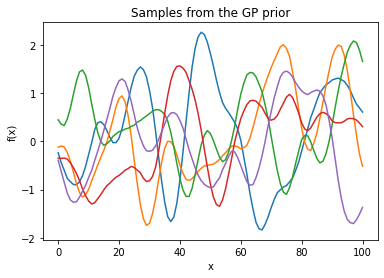

In [ ]:
mean_func = lambda xs: torch.zeros_like(xs)
kernel = lambda x1s, x2s: 1 * torch.exp(
    -0.5 * ((x1s[:, None] - x2s[None, :]) / 5)**2)
T = 100
xs = torch.linspace(0, T, T+1)
fs_samples = sample_gp(xs, mean_func, kernel, sample_shape=(5,))

# Plot the samples
for fs in fs_samples:
    plt.plot(xs, fs)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Samples from the GP prior")

## Problem 1b [Code]: Write a function to compute the 1D GP posterior predictive distribution

Given observations $\{x_n, f(x_n)\}_{n=1}^N$ with $x_n \in \mathbb{R}$ and $f(x_n) \in \mathbb{R}$, compute the posterior predictive distribution of $\{f(x_m)\}_{m=1}^M$ at new points $\{x_m\}_{m=1}^M$.

_Hint: like above, you may need to add a small amount to the diagonal of the Gram matrices._


In [ ]:
def compute_gp_predictions(xs, fs, new_xs, mean_func, kernel):
    """
    Compute the posterior predictive distribution of a 

    Args:
        xs: shape (N,) tensor specifying the observed inputs 
        fs: shape (N,) tensor specifying the observed outputs 
        new_xs: shape (M,) tensor specifying the inputs at which to evaluate the 
            posterior predictive distribution.
        mean_func: function that takes in an (N,) tensor of xs and outputs an 
            (N,) tensor of the means E[f(x)] for each x
        kernel: function that takes in (N,) tensor of xs and (M,) tensor of x's 
            and outputs a (N, M) tensor of the kernel evaluated at each pair 
            (x, x'). E.g. if the input tensors are the same, this function 
            computes the Gram matrix.
    
    Returns:
        pred_mean: shape (M,) tensor with posterior predictive mean
        pred_cov: shape (M,M) tensor with posterior predictive covariance
    """ 
    assert xs.ndim == 1
    assert fs.ndim == 1
    assert new_xs.ndim == 1

    ##
    # Schur decomps
    M = new_xs.shape[0]
    N = xs.shape[0]
    
    ### means ###
    mu_insample, mu_oos = mean_func(xs), mean_func(new_xs)

    ### covariances ###
    # squared terms
    cov_insample, cov_oos = kernel(xs, xs), kernel(new_xs, new_xs) # (N, N), (M, M)
    cov_insample += torch.eye(N) * 1e-4
    cov_oos = cov_oos + torch.eye(M) * 1e-4

    # interaction term
    cov_interact = kernel(xs, new_xs) # (N, M)

    ### PP params ###
    # 15.21: # (M, N)*(N, 1) --> (M, 1)
    mu_pp = mu_oos + cov_interact.T @ torch.linalg.solve(cov_insample, fs - mu_insample)
    # 15.22
    cov_pp = (
        cov_oos # (M, M)
        - cov_interact.T @ torch.linalg.solve(
            cov_insample, 
            cov_interact
        )
    )


    pred_mean = mu_pp
    pred_cov = cov_pp
    pred_cov += torch.eye(M) * 1e-4
    #
    ##

    # Answer might not be perfectly symmetric due to numerical precision 
    # limits. Symmetrize to be safe. 
    pred_cov = 0.5 * (pred_cov + pred_cov.T)
    return pred_mean, pred_cov

### Test that your code outputs reasonable predictions

Run the following cell to produce a plot of the GP posterior predictive distribution over the function $f(x)$ at a dense grid of test points (`new_xs`) given observations (`xs` and `ys`).

You can tweak the kernel while debugging or answer Problem 1c, but please reset to length scale $\ell = 5$ and variance $\sigma^2 4$ before submitting.

Text(0.5, 1.0, 'Posterior predictive distribution under the GP')

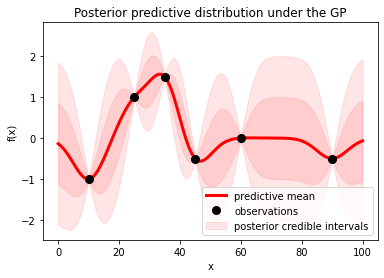

In [ ]:
T = 100
mean_func = lambda xs: torch.zeros_like(xs)
kernel = lambda x1s, x2s: 1 * torch.exp(
    -0.5 * ((x1s[:, None] - x2s[None, :]) / 5)**2)

xs = torch.tensor([10, 25, 35, 45, 60, 90], dtype=torch.float32)
fs = torch.tensor([-1.0, 1.0, 1.5, -0.5, 0.0, -0.5], dtype=torch.float32)
new_xs = torch.linspace(0, T, T+1)

pred_mean, pred_cov = compute_gp_predictions(xs, fs, new_xs, mean_func, kernel)
pred_std = torch.sqrt(torch.diag(pred_cov))

# Plot the predictive mean and the marginal predictive variance
plt.plot(new_xs, pred_mean, '-r', lw=3, label="predictive mean")
for i in range(1, 3):
    label = "posterior credible intervals" if i == 1 else None
    plt.fill_between(new_xs, 
                    pred_mean - i * pred_std, 
                    pred_mean + i * pred_std,
                    color='r', alpha=0.1,
                    label=label)

plt.plot(xs, fs, 'ko', markersize=8, label="observations")

plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc="lower right")
plt.title("Posterior predictive distribution under the GP")

## Problem 1c [Short answer] Playing with kernel hyperparameters

Describe how your predictions change when you vary the length scale or the variance of the squared exponential kernel. 

How do you think your answers would change if you instead used a Matern kernel with the same length scale and variance, but set $\nu = 1/2$?

In [ ]:
def plot_1c(l=5.0, v=1.0):
    T = 100
    mean_func = lambda xs: torch.zeros_like(xs)
    kernel = lambda x1s, x2s: v * torch.exp(
        -0.5 * ((x1s[:, None] - x2s[None, :]) / l)**2)

    xs = torch.tensor([10, 25, 35, 45, 60, 90], dtype=torch.float32)
    fs = torch.tensor([-1.0, 1.0, 1.5, -0.5, 0.0, -0.5], dtype=torch.float32)
    new_xs = torch.linspace(0, T, T+1)

    pred_mean, pred_cov = compute_gp_predictions(xs, fs, new_xs, mean_func, kernel)
    pred_std = torch.sqrt(torch.diag(pred_cov))

    # Plot the predictive mean and the marginal predictive variance
    plt.plot(new_xs, pred_mean, '-r', lw=3, label="predictive mean")
    for i in range(1, 3):
        label = "posterior credible intervals" if i == 1 else None
        plt.fill_between(new_xs, 
                        pred_mean - i * pred_std, 
                        pred_mean + i * pred_std,
                        color='r', alpha=0.1,
                        label=label)

    plt.plot(xs, fs, 'ko', markersize=8, label="observations")

    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend(loc="lower right")
    plt.title(f"Posterior Predictive: $\ell = {l}, \sigma^2 = {v}$")
    plt.show()

---

In general, experimentation with the length scale and variance yields the following:

**Length Scale**
First, consider what happens over the grid `length_scale=[.1, 1, 5, 10, 25]`, with $\sigma^2$ default:

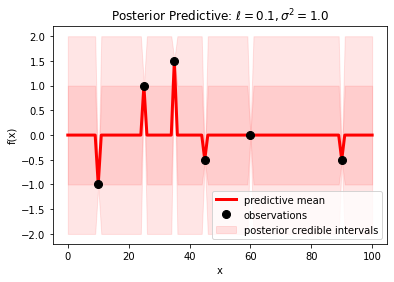

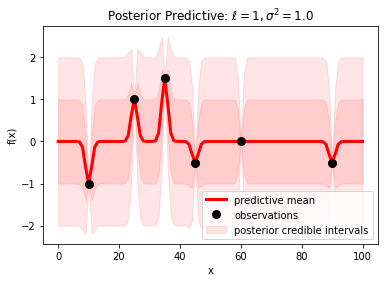

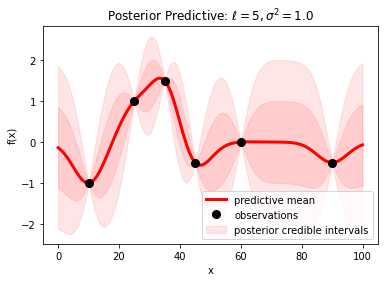

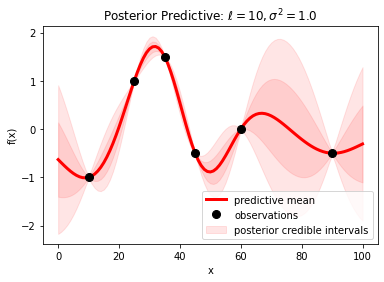

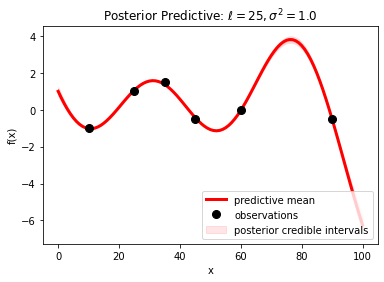

In [ ]:
for l_ in [.1, 1, 5, 10, 25]:
    plot_1c(l=l_)

Here, we see that as $\ell$ increases, two things happen. First, the predictive mean function smooths out, going from something ~ stepwise towards something that looks polynomial interpolation. Second, as $\ell$, the posterior credible interval widths shrink, such that intervals around the "step function" (small $\ell$) are quite wide and intervals around the "interpolation" (large $\ell$) are almost non-existent. 

**Variance**: Second, consider what happens over `var= [.01, .1, 1, 10, 100]`, holding constant at default $\ell  =5$. We have:

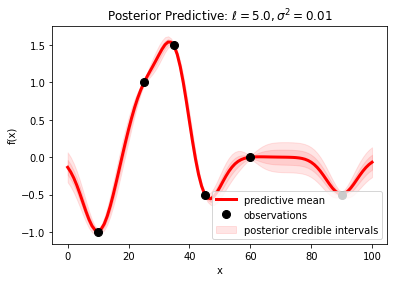

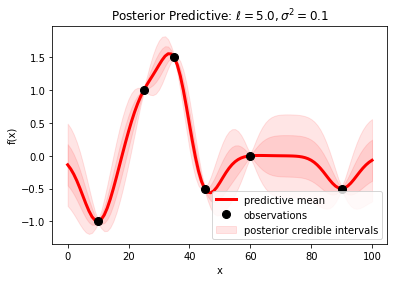

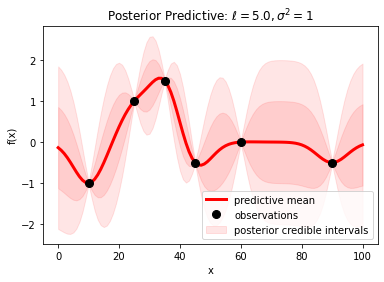

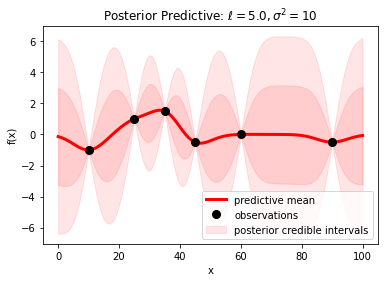

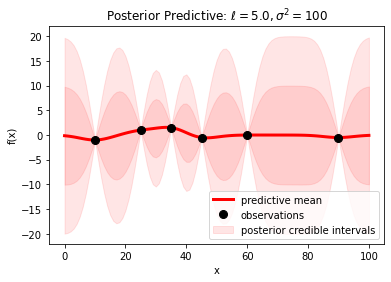

In [ ]:
for v_ in [.01, .1, 1, 10, 100]:
    plot_1c(v=v_)

Unsurprisingly, as variance increases, so do widths of the posterior credible intervals (except for at the points of interpolation, where such intervals shrink around the point). 

**Matern**
Recall the setup of the Matern kernel:
$$
K(x_i, x_j)
=
\Gamma(\nu)^{-1}2^{1-\nu}K_\nu\bigg(
\frac{\sqrt{2\eta}(x_i - x_j)}{l}
\bigg)\cdot 
\bigg(
\frac{\sqrt{2\eta}(x_i - x_j)}{l}
\bigg)^\nu
$$
Hence, when $\nu= 1/2$,
we have
$$
\Gamma(1/2)^{-1}2^{1/2}K_\nu\bigg(
\frac{(x_i - x_j)}{l}
\bigg)\cdot 
\bigg(
\frac{(x_i - x_j)}{l}
\bigg)^{1/2}.
$$
As set forth in Lecture 15, this equals $\exp\bigg(-\frac{x_i - x_j}{l}\bigg)$, i.e. the covariance function for an AR(P=1) process. This will induce a more rigid/jagged-y kernel function, as demonstrated on the visuals on page 10. Note that
$$
\exp\bigg(-\frac{x_i - x_j}{l}\bigg) = \exp\bigg(-\frac{2(x_i - x_j)}{2l}\bigg)
= \exp\bigg(-\frac{(x_i - x_j)}{2l}\bigg)^2,
$$
so this configuration is the square of the exponential Kernel above, for $\sigma^2=1$. 

---

$## Problem 1d [Code]: GP Probit Classification

Now we will write a simple Gibbs sampling algorithm for GP classification using a probit mean function.
\begin{align}
f &\sim \mathrm{GP}(\mu(\cdot), \, K(\cdot, \cdot)) \\
y_n \mid f, x_n &\sim \mathrm{Bern}(g(f(x_n)))
\end{align}
where $g(u) = \Pr(z \leq u)$ with $z \sim \mathcal{N}(0, 1))$.

First, we've written some code that generates synthetic data. 

_Note: this code relies on your solutions to Problems 1a and 1b!_

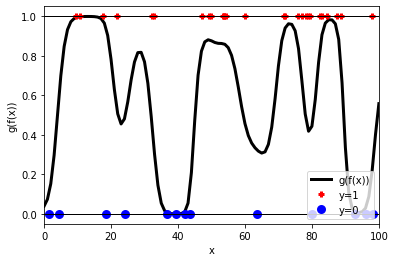

In [ ]:
torch.manual_seed(305+ord('c'))

mean_func = lambda xs: torch.zeros_like(xs)
kernel = lambda x1s, x2s: 4 * torch.exp(
    -0.5 * ((x1s[:, None] - x2s[None, :]) / 5)**2)

# Sample the GP at a random set of N points in [0, 100]
T = 100
N = 40
xs = Uniform(0, T).sample((N,))
fs_true = sample_gp(xs, mean_func, kernel)

# Sample observations from Bernoulli 
ys = Bernoulli(probit(fs_true)).sample()

# For visualization, compute the predictive mean at a grid of points
grid = torch.linspace(0, T, T+1)
f_grid_true, _ = compute_gp_predictions(xs, fs_true, grid, mean_func, kernel)

# Plot the probit of the true GP and the binary observations
plt.plot(grid, probit(f_grid_true), '-k', lw=3, label="g(f(x))")
plt.plot(xs[ys==1], torch.ones_like(xs[ys==1]), 'r+', label="y=1", mew=3)
plt.plot(xs[ys==0], torch.zeros_like(xs[ys==0]), 'bo', label="y=0", mew=3)
plt.plot([0,T], [0, 0], '-k', lw=1)
plt.plot([0,T], [1, 1], '-k', lw=1)
plt.xlabel("x")
plt.ylabel("g(f(x))")
plt.xlim(0, T)
plt.ylim(-0.05, 1.05)
plt.legend(loc="lower right")

Now you will write code to perform Gibbs sampling in this model.

We will use the augmentation scheme described in class. As we derived in class, the model above is equivalent to,
\begin{align}
f &\sim \mathrm{GP}(\mu(\cdot), \, K(\cdot, \cdot)) \\
z_n &\sim \mathcal{N}(f(x_n), 1) \\
y_n &= \mathbb{I}[z_n > 0].
\end{align}
Using this augmented model, we can perform Bayesian inference by Gibbs sampling.

Remember that, technically, $f$ is a function that has values at a continuum of points. Thankfully, we don't have to instantiate $f$ everywhere. For the Gibbs sampler, it suffices to instantiate $f$ only at the input points $f_n = f(x_n)$. That means the state of our Gibbs sampler will consist of the tuples $\{(f_n, z_n)\}_{n=1}^N$, and we will iteratively sample the following conditional distributions, 
\begin{align}
z_n &\sim p(z_n \mid f_n, y_n) \\
\mathbf{f} = (f_1, \ldots, f_N)^\top &\sim p(\mathbf{f} \mid \{x_n, z_n\}_{n=1}^N)
\end{align}

**Write code to implement each of these Gibbs updates. You may use the `OneSidedTruncatedNormal` distribution implemented at the top of this notebook.**

In [ ]:
def gibbs_sample_zs(fs, ys):
    """
    Perform a Gibbs step to sample (z_1, \ldots, z_N) from their conditional
    distribution given the function value at that point f_n = f(x_n) and the
    binary observation y_n.

    Args:
        fs: shape (N,) tensor of function evaluations at each input x_n
        ys: shape (N,) tensor of binary observations y_n

    Returns:
        zs: shape (N,) tensor of augmentation variables z_n sampled from
            their conditional distribution.
    """
    ##
    # YOUR CODE HERE
    zs = torch.zeros_like(ys)
    zs[ys == 1] = OneSidedTruncatedNormal(
        loc=fs[ys == 1], 
        scale=1., 
        lower_bound=0. 
    ).sample()
    zs[ys == 0] =  -OneSidedTruncatedNormal(
        loc=fs[ys == 0], 
        scale=1., 
        lower_bound=0. 
    ).sample()
    ##
    return zs

def gibbs_sample_fs(xs, zs, mean_func, kernel):
    """
    Sample Gaussian process values (f_1, ..., f_N) given inputs (x_1, ... x_N)
    and augmentation variables (z_1, ..., z_N). After augmentation, this reduces
    to GP Regression (see Lecture 15, Slide 17).
    """
    _SIGMA_SQ = 1.0
    ##
    N = xs.shape[0]
    # 15.15
    mu = mean_func(xs)
    G = kernel(xs, xs) + torch.eye(N) * 1e-4


    G_inv = torch.linalg.solve(
        G, torch.eye(N)
    ) + torch.eye(N) * 1e-4
    G_ = torch.linalg.solve(G_inv + _SIGMA_SQ * torch.eye(N), torch.eye(N))

    # find mean
    mu_ = G_ @ (G_inv @ mu + _SIGMA_SQ * zs)
    # enforce symmetry
    G_ = (G_ + G_.T) / 2.
    # stabilize w/ diagional add
    G_ += 1e-4 * torch.eye(N)

    
    fs = MultivariateNormal(
        mu_, 
        G_
    ).sample()
    ##
    return fs

### Test your Gibbs sampler
We have written a Gibbs loop to test your sampler on the synthetic data generated above.

In [ ]:
def gibbs(xs, ys, mean_func, kernel, num_samples=1000):
    """Simple function to iteratively update z and f.
    """
    assert xs.ndim == 1
    assert ys.ndim == 1

    # Initialize the sampler with f_n = 0 and z_n = 0
    # (zs will immediately be overwritten anyway)
    fs = torch.zeros_like(xs)
    zs = torch.zeros_like(xs)

    samples = []
    for itr in trange(num_samples):
        zs = gibbs_sample_zs(fs, ys)
        fs = gibbs_sample_fs(xs, zs, mean_func, kernel)
        samples.append((zs, fs))

    zs, fs = list(zip(*samples))
    return torch.row_stack(zs), torch.row_stack(fs)

# Run the Gibbs sampler
z_samples, f_samples = gibbs(xs, ys, mean_func, kernel)

  0%|          | 0/1000 [00:00<?, ?it/s]

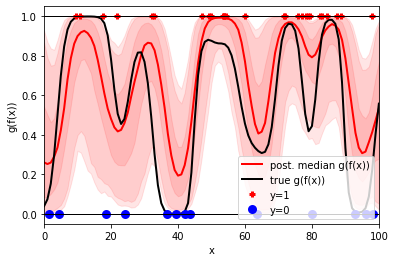

In [ ]:
# Compute GP predictions on the grid
f_grid_samples = torch.row_stack([
    compute_gp_predictions(xs, fs, grid, mean_func, kernel)[0]
    for fs in f_samples
])

# Plot the results
burnin = 100
prob_samples = probit(f_grid_samples)

# Compute the posterior median probability at each point on the grid
med_prob = torch.quantile(prob_samples[burnin:], q=.50, dim=0)
plt.plot(grid, med_prob, '-r', lw=2, label="post. median g(f(x))")

# Compute and plot posterior quantiles for each point on the grid
for lb, ub in [(.25, .75), (0.05, 0.95), (.025, .975)]:
    prob_lb = torch.quantile(prob_samples[burnin:], q=lb, dim=0)
    prob_ub = torch.quantile(prob_samples[burnin:], q=ub, dim=0)
    plt.fill_between(grid, prob_lb, prob_ub, color='r', alpha=0.1)

# Plot the true function and binary observations
plt.plot(grid, probit(f_grid_true), '-k', lw=2, label="true g(f(x))")
plt.plot(xs[ys==1], torch.ones_like(xs[ys==1]), 'r+', label="y=1", mew=3)
plt.plot(xs[ys==0], torch.zeros_like(xs[ys==0]), 'bo', label="y=0", mew=3)

# Plot the bounds
plt.plot([0,T], [0, 0], '-k', lw=1)
plt.plot([0,T], [1, 1], '-k', lw=1)

# Labels and stuff
plt.xlabel("x")
plt.ylabel("g(f(x))")
plt.xlim(0, T)
plt.ylim(-0.05, 1.05)
plt.legend(loc="lower right")

## Part 2: Poisson processes

## Problem 2a [Code]: Write a function to sample a homogeneous Poisson process 

There are many ways to do this, like we saw in Lecture 16. Use the top-down method for simplicity.


In [ ]:
def sample_homog_pp(T, intensity):
    """
    Sample a homogenous Poisson process on [0, T] with intensity lambda.

    Args:
        T: scalar length of interval
        intensity: scalar homogeneous intensity

    Returns:
        xs: (N,) tensor of times in [0, T] where N is random
    """
    ##
    # YOUR CODE HERE
    if False: # this is not top down
        total_time = torch.tensor(0.)
        xs = []
        while True:
            draw = torch.distributions.Exponential(intensity).sample()
            total_time += draw 
            if total_time > T:
                break 
            xs.append(draw)
        xs = torch.stack(xs)
    
    N = torch.distributions.Poisson(T * intensity).sample().to(int)
    xs = torch.distributions.Uniform(0, T).sample((N, ))
    #
    ##
    return xs

### Plot one of your samples

Run the cell below to plot one of your samples

number of points:  13
expected number of points:  tensor(10.)


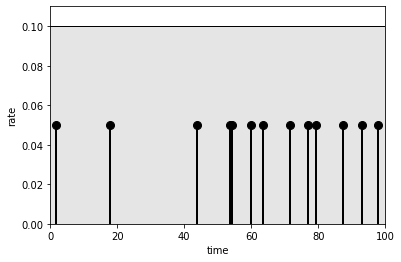

In [ ]:
def plot_pp(xs, times, rates, height=0.05):
    """Helper function to plot Poisson process.
    """
    N = len(xs)
    print("number of points: ", N)
    print("expected number of points: ", torch.trapz(rates, times))

    plt.plot(times, rates, '-k', lw=1)
    plt.fill_between(times, torch.zeros_like(rates), rates, 
                     color='k', alpha=0.1)
    for x in xs:
        plt.plot([x, x], [0, height], '-k', lw=2)
        plt.plot([x], [height], 'ko', ms=8)
    
    plt.xlim(times[0], times[-1])
    plt.ylim(0, 1.1 * rates.max())
    plt.xlabel("time")
    plt.ylabel("rate")

# Sample a homogenous Poisson process on [0, 100] with intensity .1
torch.manual_seed(305 + ord('c'))
T = 100
intensity = 0.1
xs = sample_homog_pp(T, intensity)
plot_pp(xs, torch.tensor([0, T]), torch.tensor([intensity, intensity]))

## Problem 2b [Code]: Sample an inhomogeneous Poisson process by thinning

Write a function to sample an inhomogeneous Poisson process via thinning. Assume the intensity function is upper bounded by a constant $\lambda_{\mathsf{max}}$.

In [ ]:
def sample_pp_thinning(T, intensity_func, max_intensity):
    """Sample a Poisson process via thinning.

    Args:
        T: length of time interval

        intensity_func: function that takes in a tensor of times in [0,T] and
            outputs a tensor of intensities evaluated at those times and
            in the range [0, max_intensity].

        max_intensity: upper bound on the intensity function.

    Returns:
        xs: (N,) tensor of times in [0, T] distributed according to the 
            inhomogeneous Poisson process.
    """
    ##
    # number of pts to sample
    N = torch.distributions.Poisson(max_intensity * T).sample().to(int)
    # take that many uniform draws
    U = torch.distributions.Uniform(0, T).sample((N, ))
    # eval @ intensity function
    fU = intensity_func(U)
    # make 'em probs
    thin_probs = torch.divide(fU, max_intensity)
    # thin indices
    # thin_idx = torch.where(
    #     torch.distributions.Bernoulli(probs=thin_probs).sample()
    # )[0]
    thin_idx = torch.distributions.Bernoulli(probs=thin_probs).sample()

    # do the thinning
    xs = U[thin_idx == 1]

    #
    ##
    return xs

### Test your function

Sample from an inhomogeneous Poisson process an exponentiated sinusoidal intensity function.

number of points:  53
expected number of points:  tensor(56.9896)


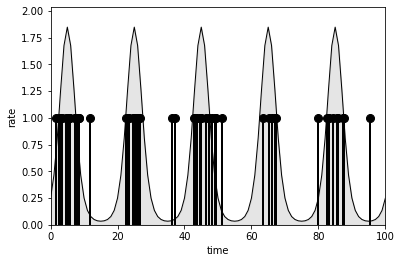

In [ ]:
torch.manual_seed(305 + ord('c'))
T = 100
intensity_func = lambda ts: 0.25 * torch.exp(
    2 * torch.sin(2 * torch.pi * ts / 20.0))
max_intensity = 0.25 * torch.exp(torch.tensor(2))
xs = sample_pp_thinning(T, intensity_func, max_intensity)

ts = torch.linspace(0, T, T+1)
intensities = intensity_func(ts)
plot_pp(xs, ts, intensities, height=1)

# Part 3: Sigmoidal Gaussian Cox Processes

A sigmoidal Gaussian Cox Process (SGCP, [Adams et al, 2009](https://homepages.inf.ed.ac.uk/imurray2/pub/09poisson/adams-murray-mackay-2009b.pdf)) is a doubly stochastic point process with intensity,
\begin{align}
\lambda(x) = g(f(x))
\end{align}
where 
\begin{align}
f &\sim \mathrm{GP}(\mu(\cdot), K(\cdot, \cdot))
\end{align}
and $g: \mathbb{R} \mapsto \mathbb{R}_+$ is a sigmoidal function. Adams et al took $g$ to be a scaled logistic function, but we will consider a scaled **probit function** instead. That is, assume,
\begin{align}
g(u) = \lambda_{\mathsf{max}}  \cdot \Pr(z \leq u) \quad \text{where} \quad z \sim \mathcal{N}(0, 1).
\end{align}

In this part of the assignment, you will write code to perform Gibbs sampling in an SGCP.

## Problem 3a [Code]: Write a function to sample an SCGP

You may use the functions you wrote for Parts 1 and 2 as well as the `probit` helper function below.

In [ ]:
def sample_scgp(T, grid, mean_func, kernel, max_intensity):
    """
    Sample a sigmoidal Gaussian Cox process.

    Args:
        T: the length of the interval
        grid: grid of (M,) times at which to return the value of the sampled GP
        mean_func: function that takes in an (N,) tensor of xs and outputs an 
            (N,) tensor of the means E[f(x)] for each x
        kernel: function that takes in (N,) tensor of xs and (M,) tensor of x's 
            and outputs a (N, M) tensor of the kernel evaluated at each pair 
            (x, x'). E.g. if the input tensors are the same, this function 
            computes the Gram matrix.
        max_intensity: the maximum intensity (\lambda_max)

    Returns:
        grid_intensity: the sampled intensity evaluated at each time in grid
        xs: a set of points drawn from the SCGP
    """
    ## 
    # YOUR CODE BELOW
    
    # 1. Sample a homogenous Poisson process. CA
    ts = sample_homog_pp(T, max_intensity); # thinning comes later
    # 2. Sample the GP from its predictive distribution at 
    #    the points drawn from the Poisson process
    fts = sample_gp(ts, mean_func, kernel);
    # 3. Accept or reject points randomly to get xs
    # Uniform
    lambda_ts = max_intensity * probit(fts)
    unif_draws = Uniform(0, max_intensity).sample(lambda_ts.shape) 
    acc_idx = unif_draws < lambda_ts; rej_idx = unif_draws >= lambda_ts

    # apply mask
    xs = ts[acc_idx]
    fts_keep = fts[acc_idx]

    # 4. Sample the GP on the grid given (ts, fts)
    mu, cov = compute_gp_predictions(
        ts,
        fts,
        grid,
        mean_func,
        kernel
    )
    f_grid = MultivariateNormal(mu, cov).sample()
    # 5. Evaluate the intensity on the grid
    grid_intensity = max_intensity * probit(f_grid)    
    #
    ##
    return grid_intensity, xs

number of points:  111
expected number of points:  tensor(101.0177)


(0.0, 2.05)

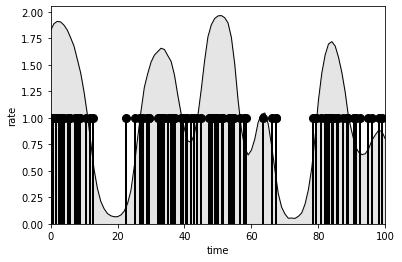

In [ ]:
# Initialize params
torch.manual_seed(305+ord('c'))
mean_func = lambda xs: torch.zeros_like(xs)
kernel = lambda x1s, x2s: 1 * torch.exp(
    -0.5 * ((x1s[:, None] - x2s[None, :]) / 5)**2)
max_intensity = 2.0

# Initialize domain
T = 100
grid = torch.linspace(0, T, T+1)
grid_intensity, xs = sample_scgp(T, grid, mean_func, kernel, max_intensity)

# Plot the sample
plot_pp(xs, grid, grid_intensity, height=1)
plt.ylim(0, max_intensity + .05)

## Problem 3b [Code]: Comment the Gibbs sampling code below 

From Parts 1 and 2, you already have all the functions you need to implement a Gibbs sampler for the sigmoidal Guassian Cox process! 

Note that in the `sample_scgp` function you rejected (thinned) a bunch of points randomly by sampling from a Bernoulli distribution with probability $g(f(x))$ where $g$ was the probit function. We can think of those accept/reject outcomes as binary latent variables. If we knew the locations of the rejected points, then inferring the GP would reduce to a GP Probit Classifcation problem, just like we implemented in Problem 1d.  

This motivates the following Gibbs sampling algorithm. The state of the Gibbs sampler will consist of the following latent variables:
- $(r_1, \ldots, r_M)$ the set of points that were rejected by the Poisson thinning algorithm. 
- $(z_1, \ldots, z_{N+M})$ the augmentation variables for the GP Classification problem at both the observed points _and_ the rejected points. 
- $(f_1, \ldots, f_{N+M})$ the GP function values at both the observed points _and_ the rejected points.

The trick is, at each iteration of the Gibbs sampler we will generate a new set of rejected points $(r_1, \ldots, r_M)$. The conditional distribution of these points is itself a Poisson process!
\begin{align}
\{r_m\}_{m=1}^M \mid f &\sim \mathrm{PP}(\lambda_{\mathsf{max}} - g(f(x))).
\end{align}
How do you sample that conditional distribution? Poisson thinning again!

Rather than implementing this yourself, we've written code to do so. Your assignment is to **comment the code below (function headers and line comments) to explain what it does.**

In [ ]:
# COMMENT THE FUNCTIONS AND LINES BELOW

def gibbs_update_rs(xs, fxs, rs, frs, 
                    mean_func, kernel, max_intensity):
    """
    Takes a single Gibbs step to obtain updated rejected terms, namely 
    new rs, frs.

    It may be helpful to think of the adverserial/complementary Poisson thinning, as used 
    sample from two Poisson processes, as having an "A-side" and a "B-side." 
    Specifically, the acceptances of the A-side are the rejections for the B-side (and
    vice versa); equivalently, the rejections for the A-side are the acceptances for the B-side,
    and vice versa. 

    Args:
      xs : torch.tensor(Na)
        A tensor of xs from previously "accepted" points, after Poisson thinning. That is,
        previous A-side points. 
      fxs: torch.tensor(Na)
        A tensor of GP values whose indices correspond to the previously accepted xs. That is, f
        GP function samples at the A-side points. 
      rs : torch.tensor(Nr)
        A tensor of xs from previously "rejected" points, from the complementary Poisson thinning
        for x. That is, previous B-side points.
      frs: torch.tensor(Nr)
        A tensor of GP values whose indices correspond to the previous rejections. That is,
        GP function samples at the  B-side points.
      mean_func: function that takes in an (N,) tensor of xs and outputs an 
            (N,) tensor of the means E[f(x)] for each x
      kernel: function that takes in (N,) tensor of xs and (M,) tensor of x's 
          and outputs a (N, M) tensor of the kernel evaluated at each pair 
          (x, x'). E.g. if the input tensors are the same, this function 
          computes the Gram matrix.
      max_intensity: upper bound on the intensity function.
      
    Returns : tuple[torch.tensor(Nr', Nr')]
      A tuple of:
        * New B-side points
        * GP values corresponding to those B-side points
      
    """
    ### 1. ###
    # This just samples a homogenous poisson process ~ (lambda = max_intensity), 
    # as was done above. This is the same in length to the accepted xs & fxs (denoted xs, fxs) and 
    # rejected xs & fxs (denoted rxs, frs), so that it can serve as the "underlying" ts
    # in compute gp_predictions_below.
    ts = sample_homog_pp(T, max_intensity)

    ### 2. ###
    # Here, we're (i) re-assembling the xs and fxs by bandaging the rejected points back on, (ii)
    # then computing a posterior predictive for the bandaged sequence, and (iii) taking a single
    # draw from that post. pred. distribution.
    mu, Sigma = compute_gp_predictions(
        torch.cat([xs, rs]), torch.cat([fxs, frs]), ts, 
        mean_func, kernel)
    # Then, we take a draw from this MVN for not-yet-thinned posterior fts
    fts = MultivariateNormal(mu, Sigma).sample()

    ### 3. ###
    # Next, we evaluate the intensity for the purpose of thinning. Note we use 
    # 1 - g(fts), since this B-side process is conditioned on 1 - probit(fts). Intuitively
    # this makes sense; if the A-side accepts ~ probit(fts), then the rejection (B-side acceptance) 
    # should occur ~ 1 - probit
    lambda_ts = max_intensity * (1 - probit(fts))

    ### 4. ###
    # Use the uniform trick to obtain indices at which we accept, and 
    # use those to slice ts, fts
    accept = Uniform(0, max_intensity).sample((len(ts),)) < lambda_ts
    return ts[accept], fts[accept]

def gibbs(xs, T, grid, mean_func, kernel, max_intensity, num_samples=2000):
    """
    Performs full on gibbs-sampling in order to update (A-side, B-side):
      * [xs; rs]
      * [fxs; frs]
      * [zs]

    Args:
      xs : torch.tensor(N, )
        A tensor of xs data points
      T : the length of the interval
      grid: grid of (M,) times at which to return the value of the sampled GP
      mean_func: function that takes in an (N,) tensor of xs and outputs an 
            (N,) tensor of the means E[f(x)] for each x
      kernel: function that takes in (N,) tensor of xs and (M,) tensor of x's 
            and outputs a (N, M) tensor of the kernel evaluated at each pair 
            (x, x'). E.g. if the input tensors are the same, this function 
            computes the Gram matrix.
      max_intensity: the maximum intensity (\lambda_max)
      num_samples : int 
        Number of Gibbs iters to run

    """
    assert xs.ndim == 1
    N = len(xs) # active number of accepted xi in the sampler(A-side)

    ### 1. ###
    # instantiate fxi all to zero, for each xi
    fxs = torch.zeros_like(xs)
    # instantiate rejected xi; begin with no rejections
    rs = torch.tensor([])
    # instantiate rejected fxi; again, begins empty
    frs = torch.zeros_like(rs)
    # active number of rejected xi in the sampler (B-side)
    M = len(rs)

    f_grid_samples = []
    for itr in trange(num_samples):
        ### 2. ### 
        # Perform an update of the rejected xi, as well as the f(xi) corresponding to those rejections. 
        # per Gibbs, draw from full conditional
        rs, frs = gibbs_update_rs(xs, fxs, rs, frs, 
                                  mean_func, kernel, max_intensity)
        # update active number of rejections
        M = len(rs)

        ### 3. ### 
        # take a full conditional draw for z_i | -. 
        zs = gibbs_sample_zs(torch.cat([fxs, frs]), 
                             torch.cat([torch.ones(N), torch.zeros(M)]))

        ### 4. ### 
        # Update the GP evaluations at all of the accepted/rejected points, where
        # we have conditioned on accepted points xs, rejected points rs, and z values 
        # (and of course kernel and mean function)
        fs = gibbs_sample_fs(torch.cat([xs, rs]), zs, mean_func, kernel)
        # update the accept/reject partition over the fs
        fxs, frs = fs[:N], fs[N:]

        ### 5. ### 
        # Compute the PP mean at each of the grid points;
        # as above, rejected points are binded on after the accepted points
        f_grid, _ = compute_gp_predictions(torch.cat([xs, rs]), 
                                           torch.cat([fxs, frs]), 
                                           grid, mean_func, kernel)
        #
        f_grid_samples.append(f_grid)
        
    f_grid_samples = torch.row_stack(f_grid_samples)
    return f_grid_samples, rs


### Now let's see if it works!

In [ ]:
# Run the Gibbs sampler. It may take a minute.
torch.manual_seed(305+ord('c'))
f_grid_samples, rs = gibbs(xs, T, grid, mean_func, kernel, max_intensity)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Posterior distribution of $\\lambda(x)$')

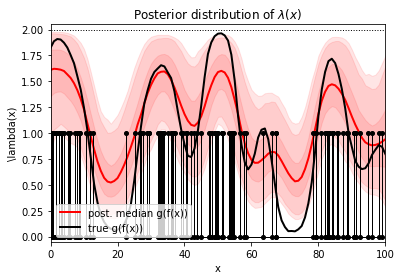

In [ ]:
# Plot the results
burnin = 0
intensity_samples = max_intensity * probit(f_grid_samples)

# Compute the posterior median probability at each point on the grid
med_prob = torch.quantile(intensity_samples[burnin:], q=.50, dim=0)
plt.plot(grid, med_prob, '-r', lw=2, label="post. median g(f(x))")

# Compute and plot posterior quantiles for each point on the grid
for lb, ub in [(.25, .75), (0.05, 0.95), (.025, .975)]:
    intensity_lb = torch.quantile(intensity_samples[burnin:], q=lb, dim=0)
    intensity_ub = torch.quantile(intensity_samples[burnin:], q=ub, dim=0)
    plt.fill_between(grid, intensity_lb, intensity_ub, color='r', alpha=0.1)

# Plot the true function and binary observations
plt.plot(grid, grid_intensity, '-k', lw=2, label="true g(f(x))")
for x in xs:
    plt.plot([x, x], [0, 1], '-ko', lw=1, ms=4)

# Plot the bounds
plt.plot([0,T], [0, 0], '-k', lw=1)
plt.plot([0,T], max_intensity * torch.ones(2), ':k', lw=1)

# Labels and stuff
plt.xlabel("x")
plt.ylabel("\lambda(x)")
plt.xlim(0, T)
plt.ylim(-0.05, max_intensity + .05)
plt.legend(loc="lower left")
plt.title("Posterior distribution of $\lambda(x)$")

## Problem 3c [Short Answer]: Computational efficiency

Answer the following questions:
- You may have noticed that the number of iterations per second jumps around a bit during the course of sampling. What could cause that to happen?

- Suppose that we set the max intensity to $\lambda_{\mathsf{max}} = 10$. How would that affect the run time of the Gibbs sampler and why?



---

First, recall that matrix inversion is $\mathcal{O}(n^3)$, a pretty expensive operation. Then, note that such an operation is called four times over the course of a Gibbs iteration (twice in `compute_gp_predictions()`; twice in `gibbs_sample_fs()`). Hence, when the arguments `torch.cat([xs, rs])` passed to `compute_gp_predictions()` is long (owing to a long `rs` draw; `xs` are held throughout), the inversion in this function becomes that much more expensive. So if the complementary/adverserial thinning step yields a big haul of `rs`, we'll put the `compute_gp_predictions()` function, and in particular, the inversion inside of it, under a lot of stress. This may cause a slow iteration.

Next, ompare a $\lambda_{\max} = 2$, the default, with $\lambda_{\max} = 10$. 


In [ ]:
%timeit
torch.manual_seed(305+ord('c'))
f_grid_samples, rs = gibbs(xs, T, grid, mean_func, kernel, max_intensity)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
%timeit
torch.manual_seed(305+ord('c'))
f_grid_samples, rs = gibbs(xs, T, grid, mean_func, kernel, 10.)

  0%|          | 0/2000 [00:00<?, ?it/s]

As we see, the $\lambda_{max} = 10$ version takes considerably longer: whereas $\lambda_{max} = 2$ takes approximately 45 seconds, $\lambda_{max} = 10$ takes over 17 minutes!

In large part, this performance gap owes back to the first part of the question, where we have imbalanced `xs` and `rs` counts and hence big inversions to make. To see why this would be the case, think about what's happening in `gibbs_sample_rs()`, the function that partitions the `xs` from `rs`. 

1.) First, we do:

```
ts = sample_homog_pp(T, max_intensity)
```
Due to the increased max intensity, we should see a lot more arrivals, so `ts`, from which we thin, is already much longer.

2.) Then, we do 


```
mu, Sigma = compute_gp_predictions(
        torch.cat([xs, rs]), torch.cat([fxs, frs]), ts, 
        mean_func, kernel)

fts = MultivariateNormal(mu, Sigma).sample()
```
To get our to-be-thinned `fts`. We'll return to this step later. Due to the increased length of `ts`, we know that `fts` will be longer as well

3.) 

We do 

```
lambda_ts = max_intensity * (1 - probit(fts))
accept = Uniform(0, max_intensity).sample((len(ts),)) < lambda_ts
rs = ts[accept]
frs = fts[accept]
```
Here, since `ts`, and in turn `fts` is much longer, more points will "get through" the accept/reject gate. As such, `rs` will be longer, leading to a longer vector passed into `compute_gp_predictions()` on the next iteration. As before, it'll be a bigger matrix inversion here, and a much slower sampler as a result.

---

## Bonus [math]: Gibbs updates for $\lambda_{\mathsf{max}}$

Derive a closed form Gibbs update for $\lambda_{\mathsf{max}}$ given the remaining variables (including the latent variables like the rejected spikes, etc.).

---

_Your answer here._

---

**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw8_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf files to Gradescope. 